In [1]:

!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv


--2024-08-31 16:24:53--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  5.15MB/s    in 0.3s    

2024-08-31 16:24:54 (5.15 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [176]:
import pandas as pd

url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
df = pd.read_csv(url)

In [177]:
features = [
    'Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
    'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP'
]

df = df[features].copy()

df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)

mean_price = df.msrp.mean()
df['above_average'] = (df.msrp >= mean_price).astype(int)
df.head()

del df['msrp']

In [178]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [179]:
(y_train == 1).sum(), (y_train == 0).sum()

(np.int64(1953), np.int64(5195))

In [180]:
from sklearn.metrics import roc_auc_score, roc_curve

numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%16s, %.3f' % (c, auc))

            year, 0.688
       engine_hp, 0.917
engine_cylinders, 0.766
     highway_mpg, 0.633
        city_mpg, 0.673


highway_mpg and city_mpg has auc score below 0.5. AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

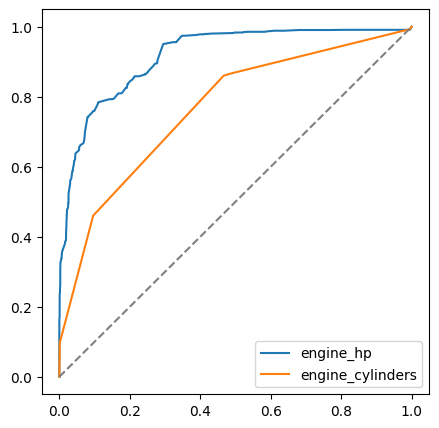

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.engine_hp)
plt.plot(fpr, tpr, label='engine_hp')

fpr, tpr, _ = roc_curve(y_train, df_train.engine_cylinders)
plt.plot(fpr, tpr, label='engine_cylinders')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

In [182]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [183]:
(y_pred >= 0.5).sum()    

np.int64(638)

In [184]:
roc_auc_score(y_val, y_pred)

np.float64(0.9763567351689031)

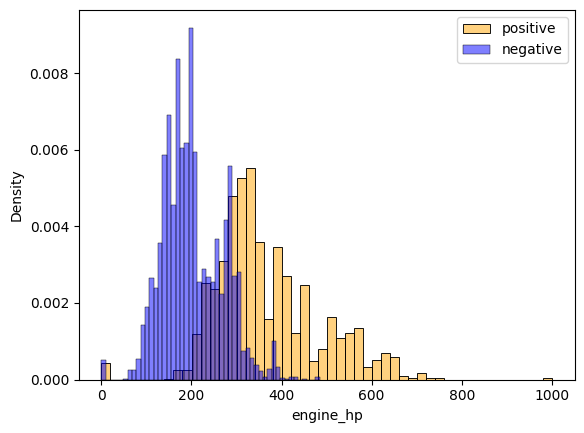

In [185]:
import seaborn as sns
sns.histplot(df_train.engine_hp[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.engine_hp[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

In [186]:
y_pred

array([0.60080037, 0.02068085, 0.48799793, ..., 0.00664027, 0.99998209,
       0.09040401])

In [187]:
roc_auc_score(y_val, y_pred)

np.float64(0.9763567351689031)

In [188]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)
    

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [189]:
t = 0.5
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

pd.DataFrame([[tp, fp], [fn, tn]], columns=['predicted 1', 'predicted 0'], index=['actual 1', 'actual 0'])

,predicted 1,predicted 0
actual 1,566,72
actual 0,88,1657


In [190]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,362,10,1367
20,0.2,624,223,30,1506
30,0.3,604,155,50,1574
40,0.4,584,110,70,1619
50,0.5,566,72,88,1657
60,0.6,516,51,138,1678
70,0.7,482,28,172,1701
80,0.8,426,12,228,1717
90,0.9,344,4,310,1725


In [191]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [192]:
df_scores[::10]

,threshold,tp,fp,fn,tn,p,r
0,0.0,654,1729,0,0,0.274444,1.000000
10,0.1,644,362,10,1367,0.640159,0.984709
20,0.2,624,223,30,1506,0.736718,0.954128
30,0.3,604,155,50,1574,0.795784,0.923547
40,0.4,584,110,70,1619,0.841499,0.892966
50,0.5,566,72,88,1657,0.887147,0.865443
60,0.6,516,51,138,1678,0.910053,0.788991
70,0.7,482,28,172,1701,0.945098,0.737003
80,0.8,426,12,228,1717,0.972603,0.651376
90,0.9,344,4,310,1725,0.988506,0.525994


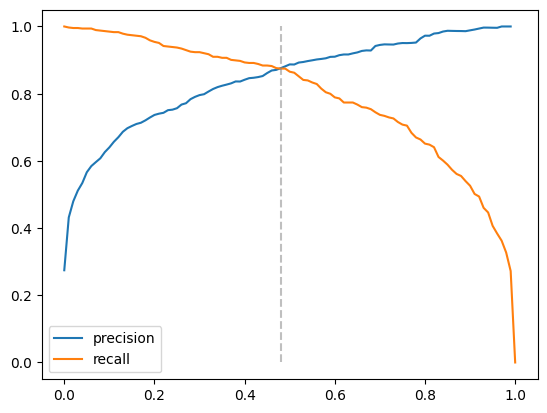

In [193]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.48, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

In [195]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [196]:
df_scores.loc[df_scores.f1.argmax()]

threshold       0.490000
tp            572.000000
fp             77.000000
fn             82.000000
tn           1652.000000
p               0.881356
r               0.874618
f1              0.877974
Name: 49, dtype: float64

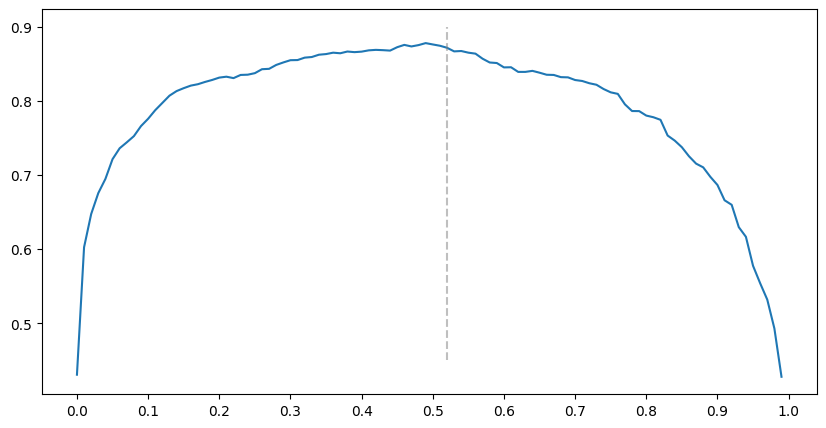

In [197]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.52, 0.45, 0.9, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [198]:
from sklearn.model_selection import KFold

In [199]:
columns = list(df.columns)
columns.remove('above_average')
columns

['make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']

In [200]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [202]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.978 +- 0.000
